In [1]:
# pyright: analyzeUnannotatedFunctions=true

# ARIMA

In [2]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook

In [3]:
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [10, 7.5]

## Import data

In [4]:
data = pd.read_csv("jj.csv")
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


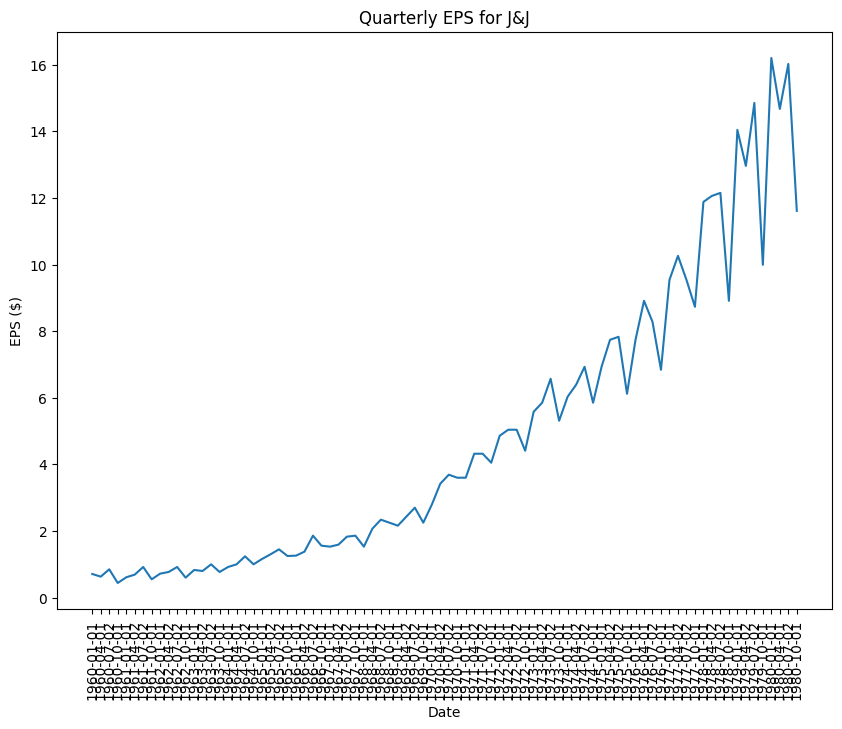

In [5]:
plt.plot(data["date"], data["data"])
plt.title("Quarterly EPS for J&J")
plt.xlabel("Date")
plt.ylabel("EPS ($)")
plt.xticks(rotation=90);  # fmt: skip

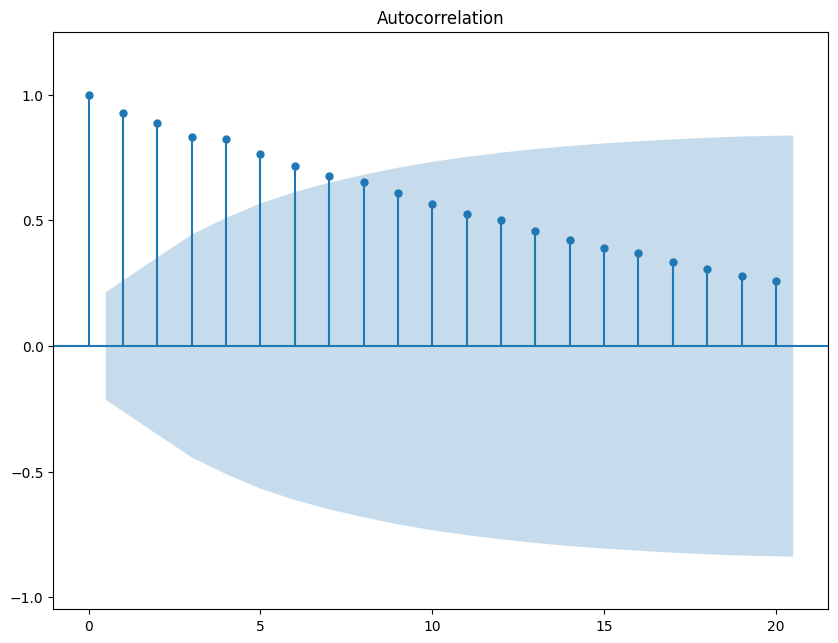

In [6]:
plot_acf(data["data"], auto_ylims=True);  # fmt: skip

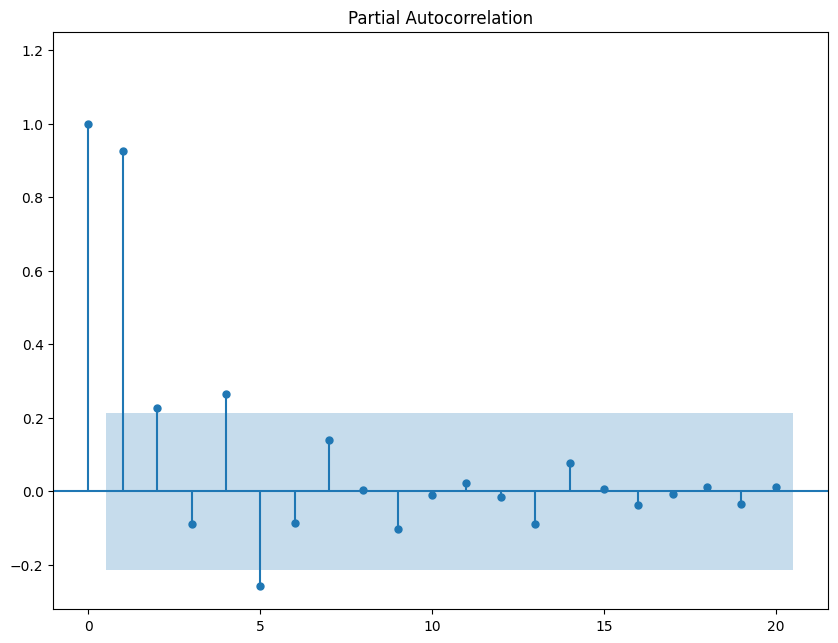

In [7]:
plot_pacf(data["data"], auto_ylims=True);  # fmt: skip

In [8]:
data["data_tr_1"] = np.log(data["data"])
data["data_tr_1"] = data["data_tr_1"].diff()
data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


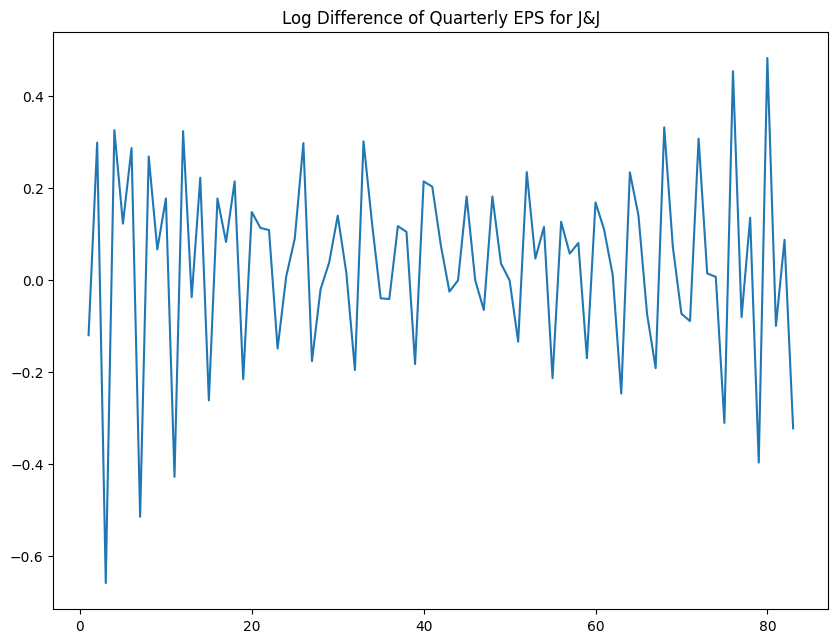

In [9]:
plt.plot(data["data_tr_1"])
plt.title("Log Difference of Quarterly EPS for J&J");  # fmt: skip

In [10]:
ad_fuller_result = adfuller(data["data_tr_1"][1:])
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -4.317043945811837
p-value: 0.00041497314044406584


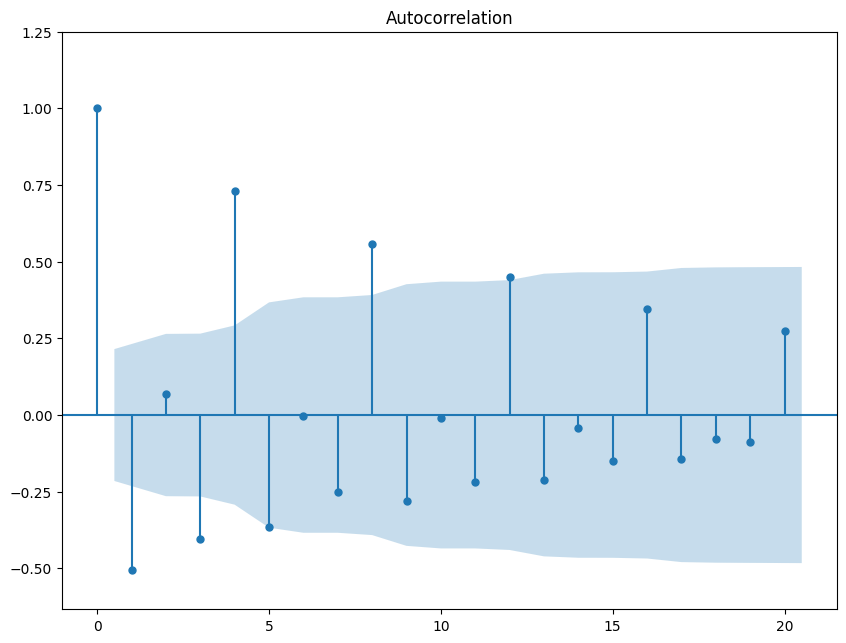

In [11]:
plot_acf(data["data_tr_1"][1:], auto_ylims=True);  # fmt: skip

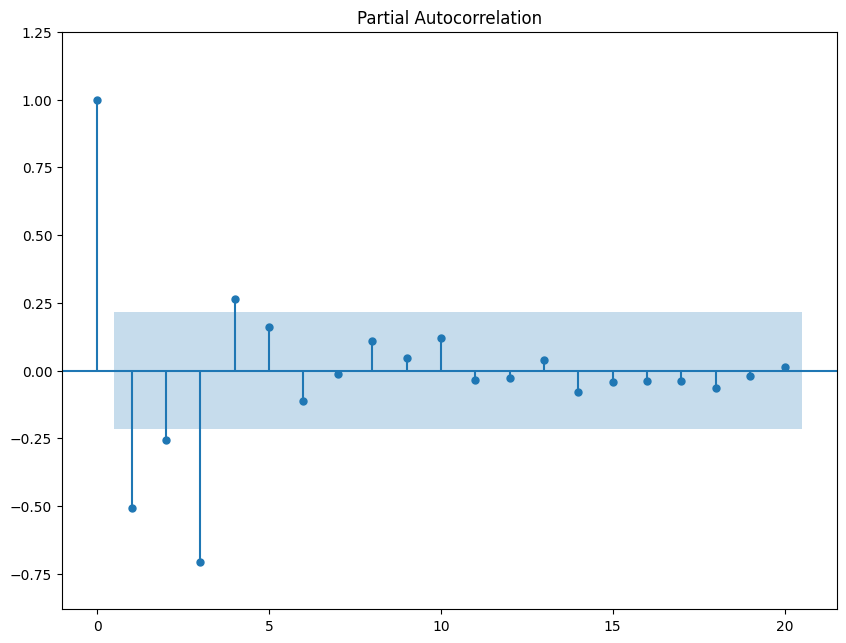

In [12]:
plot_pacf(data["data_tr_1"][1:], auto_ylims=True);  # fmt: skip

In [13]:
def optimize_ARIMA(endog, order_list):
    """
    Returns a DataFrame with parameters and corresponding AIC

    endog - The observed variable
    order_list - List with (p, d, q) tuples
    """
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=order,
                simple_differencing=False,
            ).fit(disp=False)
        except:
            continue
        results.append([order, model.aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, d, q)", "AIC"]
    results_df = results_df.sort_values(by="AIC").reset_index(drop=True)
    return results_df

In [14]:
ps = range(8)
d = 1
qs = range(8)

order_list = list(map(lambda t: (t[0], d, t[1]), product(ps, qs)))
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [15]:
results_df = optimize_ARIMA(data["data"], order_list)
results_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(6, 1, 3)",115.297318
1,"(4, 1, 6)",115.859233
2,"(7, 1, 1)",116.050450
3,"(5, 1, 3)",116.536224
4,"(5, 1, 4)",117.242599
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [16]:
best_model = SARIMAX(
    data["data"], order=(6, 1, 3), simple_differencing=False
)
res = best_model.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.649
Date:                Thu, 31 Aug 2023   AIC                            115.297
Time:                        20:33:05   BIC                            139.486
Sample:                             0   HQIC                           125.015
                                 - 84                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4733      0.127    -11.640      0.000      -1.721      -1.225
ar.L2         -0.7728      0.148     -5.235      0.000      -1.062      -0.484
ar.L3          0.0382      0.063      0.610      0.542      -0.085       0.161
ar.L4          1.0151      0.045     22.310      0.000       0.926       1.104
ar.L5          1.4356      0.134     10.685      0.000       1.172       1.699
ar.L6          0.7430      0.149      4.985      0.000       0.451       1.035
ma.L1          0.7232      0.126      5.731      0.000       0.476       0.970
ma.L2         -0.1461      0.113     -1.294      0.196      -0.367       0.075
ma.L3         -0.7213      0.081     -8.940      0.000      -0.879      -0.563
sigma2         0.1543      0.024      6.310      0.000       0.106       0.202
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                65.05
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):              39.65   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

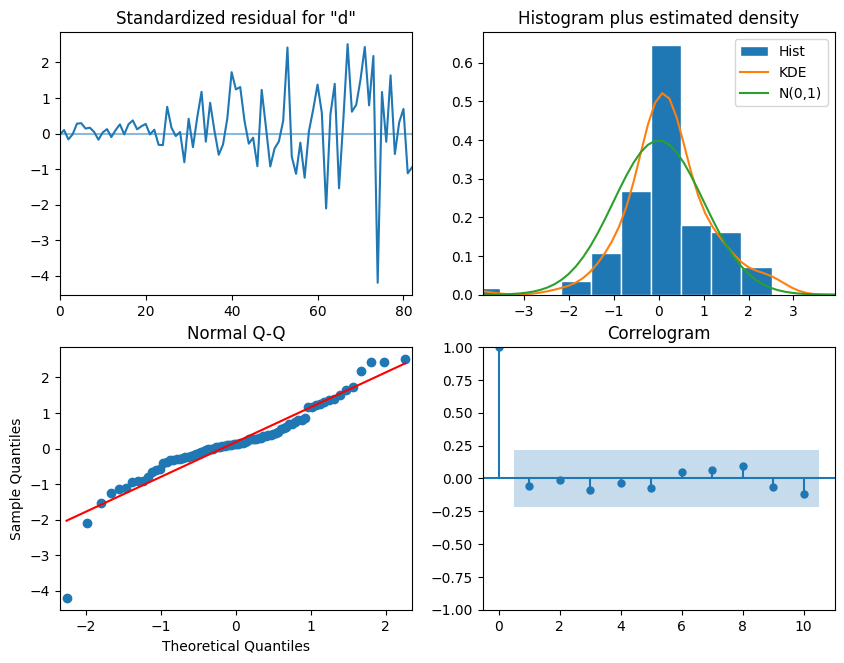

In [17]:
res.plot_diagnostics();  # fmt: skip

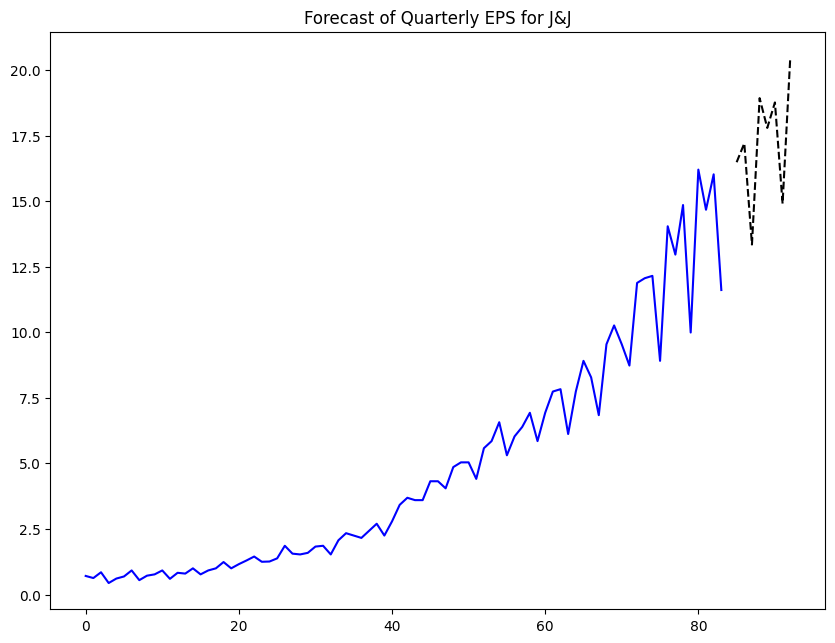

In [18]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data["data"], "blue")
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], "k--")
ax.set_title("Forecast of Quarterly EPS for J&J");  # fmt: skip

In [19]:
data["model"] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.677077
3,1960-10-01,0.44,-0.658462,0.727089
4,1961-01-01,0.61,0.326684,0.643088
5,1961-04-02,0.69,0.123233,0.528346
6,1961-07-02,0.92,0.287682,0.790120
7,1961-10-01,0.55,-0.514455,0.487383
8,1962-01-01,0.72,0.269333,0.649695
9,1962-04-02,0.77,0.067139,0.751664


In [20]:
mse = mean_squared_error(data["data"], data["model"])
print(f"MSE: {mse}")

MSE: 0.15992650411686765
